In [1]:
import torch
import torch.nn as nn
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt

In [2]:
# set working directory
working_dir = "/projects/bcnx/kazumak2/MIMONet/Subchannel/"
data_dir = os.path.join(working_dir, "data")

### Load Edge Information

In [3]:
# trunk dataset
trunk_input = np.load(os.path.join(data_dir, "share/trunk_input.npz"))['trunk']

### Load Test Results

In [4]:
result_dir = os.path.join(working_dir, "results")

In [9]:
results = np.load(os.path.join(result_dir, "test_results.npz"))

# Extracting the results
gt_branch1 = results['branch1']
gt_branch2 = results['branch2']

pred = results['predictions']
gt_target = results['targets']

# printing the shapes
print(f"Shape of gt_branch1: {gt_branch1.shape}")
print(f"Shape of gt_branch2: {gt_branch2.shape}")
print(f"Shape of pred: {pred.shape}")
print(f"Shape of gt_target: {gt_target.shape}")

Shape of gt_branch1: (1000, 100)
Shape of gt_branch2: (1000, 2)
Shape of pred: (1000, 1733, 3)
Shape of gt_target: (1000, 1733, 3)


## MSE

In [30]:
# Compute squared error over grid points for each sample and channel
squared_error = (pred - gt_target) ** 2  # shape: (samples, grid_points, channels)

# Mean over grid points for each sample and channel
mse_per_sample = np.mean(squared_error, axis=1)  # shape: (samples, channels)

# Mean over all samples for each channel
mse_per_channel = np.mean(mse_per_sample, axis=0)  # shape: (channels,)

print("MSE per channel:", mse_per_channel)

# standard deviation of MSE per channel
std_per_channel = np.std(mse_per_sample, axis=0)  # shape: (channels,)
print("Standard deviation of MSE per channel:", std_per_channel)

MSE per channel: [8.5351225e-03 2.8475051e+00 8.0484187e-06]
Standard deviation of MSE per channel: [9.7429863e-04 2.8137650e+00 1.7200066e-06]


## Mean Relative L2 Errors

In [70]:
# pred and gt_target are numpy arrays of shape (samples, grid_points, channels)

# Compute L2 norm over grid points for each sample and channel
l2_pred = np.linalg.norm(pred, axis=1)  # shape: (samples, channels)
l2_gt = np.linalg.norm(gt_target, axis=1)  # shape: (samples, channels)

# Compute L2 error over grid points for each sample and channel
l2_err = np.linalg.norm(pred - gt_target, axis=1)  # shape: (samples, channels)

# Compute relative error (avoid division by zero)
rel_err = l2_err / (l2_gt + 1e-8)  # shape: (samples, channels)

# Mean over samples for each channel
mean_rel_err_per_channel = np.mean(rel_err, axis=0)  # shape: (channels,)

print("Mean relative L2 error per channel:", mean_rel_err_per_channel)

# standard deviation of relative error per channel
std_rel_err_per_channel = np.std(rel_err, axis=0)  # shape: (channels,)
print("Standard deviation of relative L2 error per channel:", std_rel_err_per_channel)

Mean relative L2 error per channel: [0.02211115 0.00268162 0.04149625]
Standard deviation of relative L2 error per channel: [0.00022993 0.00116533 0.00037741]


ch0 -> velocity [m/s]  
ch1 -> temperature [K]  
ch2 -> tke [m^2/s^2]

In [99]:

import pandas as pd

df = pd.DataFrame()

df['ch0'] = rel_err[:, 0] * 100  # Convert to percentage
df['ch1'] = rel_err[:, 1] * 100  # Convert to percentage
df['ch2'] = rel_err[:, 2] * 100  # Convert to percentage

# compute the mean over all channel per sample
df['mean'] = df.mean(axis=1)

# get the idx of the maximum mean and minimum mean
max_idx = df['mean'].idxmax()
min_idx = df['mean'].idxmin()
print(f"Sample with maximum mean relative error: {max_idx}, Mean: {df['mean'][max_idx]}")
print(f"Sample with minimum mean relative error: {min_idx}, Mean: {df['mean'][min_idx]}")

Sample with maximum mean relative error: 20, Mean: 2.3699328899383545
Sample with minimum mean relative error: 778, Mean: 2.144258737564087


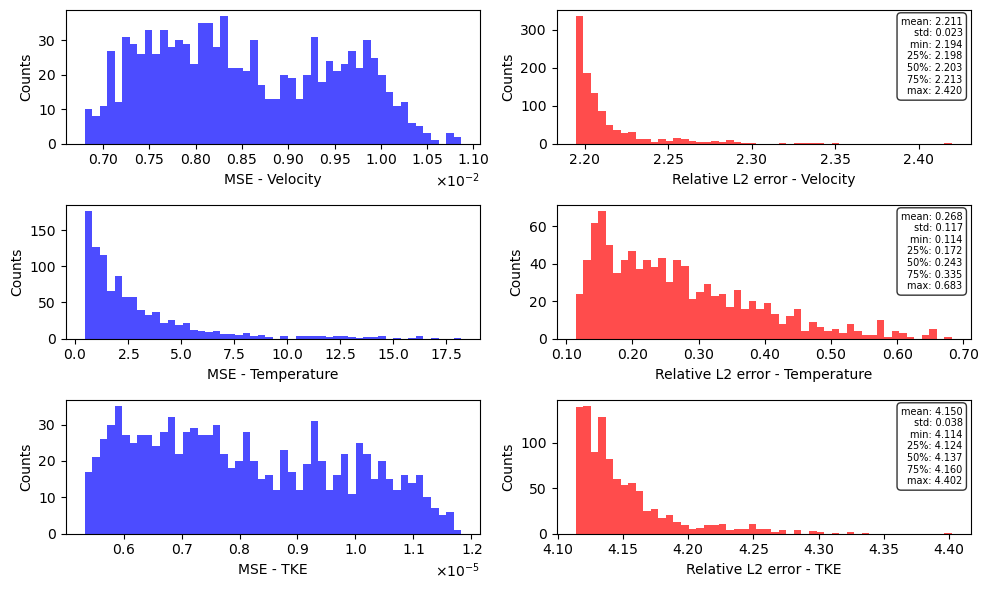

In [95]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

fig, ax = plt.subplots(3, 2, figsize=(10, 6))

channel_names = ['Velocity', 'Temperature', 'TKE']
mse_labels = [f"MSE - {name}" for name in channel_names]
rel_labels = [f"Relative L2 error - {name}" for name in channel_names]

# Create DataFrame from relative errors (in %)
df = pd.DataFrame({
    'ch0': rel_err[:, 0] * 100,
    'ch1': rel_err[:, 1] * 100,
    'ch2': rel_err[:, 2] * 100,
})

for i in range(3):
    # MSE
    ax[i, 0].hist(mse_per_sample[:, i], bins=50, color='blue', alpha=0.7)
    ax[i, 0].set_xlabel(mse_labels[i])
    ax[i, 0].set_ylabel('Counts')
    # Set scientific notation for MSE axis
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    ax[i, 0].xaxis.set_major_formatter(formatter)

    # Relative L2
    ax[i, 1].hist(df[f'ch{i}'], bins=50, color='red', alpha=0.7)
    ax[i, 1].set_xlabel(rel_labels[i])
    ax[i, 1].set_ylabel('Counts')
    ax[i, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Format statistics (excluding 'count')
    stats = df[f'ch{i}'].describe().drop(['count'])
    stats_str = '\n'.join([f"{idx}: {val:.3f}" for idx, val in stats.items()])

    # Add stats box
    ax[i, 1].text(
        0.98, 0.95, stats_str,
        transform=ax[i, 1].transAxes,
        fontsize=7,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8)
    )

plt.tight_layout()
plt.show()